In [438]:
import os
import re
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [439]:
warmup_time = 24*28

In [440]:
# fn = input()
# print(fn.replace("\\","/"))

In [441]:
#run_root = "C:/JSPRuns/2025-03-11-093150_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2"
#run_root = "C:/JSPRuns/2025-03-11-163216_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2"
run_root = "C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2"
#run_root = "C:/Users/AndreAlmeida/Temp/2025-03-13-165626_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2"

In [442]:
def read_dat(dat_file):
    dfdat = pd.read_csv(dat_file,delimiter="\t")
    # unnamed columns indicate a multi-run dat file with a last row containing stats
    if any(dfdat.columns.str.match(r"^Unnamed")):
        dfdat = dfdat.iloc[:-1]

    dfdat = dfdat.loc[:,~dfdat.columns.str.match(r"^Unnamed")]
    
    dfdat.loc[:,"run_path"] = os.path.splitext(os.path.split(dat_file)[-1])[0]
    
    return dfdat

for proot, dirs, files in os.walk(os.path.join(run_root,"Outputs")):
    for f in files:
        if re.match(r".*\.dat", f):
            print(f)
            dat_file = os.path.join(proot, f)
            
            dfdat = read_dat(dat_file)
            break

dfdat

5102_Base_3x80ocFLTrn_Quebec_pls2.dat


,Scenario,Replication,[Simulation].RunNumber,sum([cvToMarine].TotalIn)/1[Mt],[cvToMarine].TotalIn([Concentrate])/1[Mt],[cvToMarine].TotalIn([Pellets])/1[Mt],[cvMWUnloadFL].TotalIn([Ore])/1[Mt],[mineMW].TotalContentsRemoved/1[Mt],sum([cvPC1a].TotalIn)/1[Mt],run_path
0,1,1.0,1.0,25.566000,15.822000,9.744000,22.535700,52.651922,25.436893,5102_Base_3x80ocFLTrn_Quebec_pls2
1,1,2.0,2.0,25.308780,15.498780,9.810000,22.426560,52.101036,25.250280,5102_Base_3x80ocFLTrn_Quebec_pls2
2,1,3.0,3.0,25.296581,15.534000,9.762581,22.526400,52.223706,25.285060,5102_Base_3x80ocFLTrn_Quebec_pls2
3,1,4.0,4.0,25.744756,15.952756,9.792000,22.463103,53.287511,25.593079,5102_Base_3x80ocFLTrn_Quebec_pls2
4,1,5.0,5.0,25.334055,15.671917,9.662138,22.507478,52.813223,25.532280,5102_Base_3x80ocFLTrn_Quebec_pls2
5,1,6.0,6.0,25.571724,15.602000,9.969724,22.434063,51.296326,25.391346,5102_Base_3x80ocFLTrn_Quebec_pls2
6,1,7.0,7.0,25.727400,15.893400,9.834000,22.458143,53.100830,25.571760,5102_Base_3x80ocFLTrn_Quebec_pls2
7,1,8.0,8.0,25.320998,15.702002,9.618996,22.389120,52.858438,25.471047,5102_Base_3x80ocFLTrn_Quebec_pls2
8,1,9.0,9.0,25.262395,15.564786,9.697609,22.389808,52.144385,25.449090,5102_Base_3x80ocFLTrn_Quebec_pls2
9,1,10.0,10.0,25.492000,15.680000,9.812000,22.353495,52.811856,25.473072,5102_Base_3x80ocFLTrn_Quebec_pls2


In [443]:
def int_or_float_or_str(x):
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return x
        
def find_empty_line_no(f):
    lno=0
    with open(f,"r") as fid:
        for line in fid:
            if len(line) < 2:
                return lno
            lno += 1

def read_multi_run_log_single_file(filename):
    with open(filename,"r") as f:
        log_lines=[]
        dfs=[]
        current_repl = 0
        for line in f:
            if line[0] == '#':
                #print(line)
                m = re.match(r'^.*SCENARIO\s+(\d+)\s+-\s+REPLICATION\s+(\d+).*',line)
                if m:
                    scenario, repl = m.groups()
                if len(log_lines) > 0:
                    df = pd.DataFrame(log_lines[1:],columns=log_lines[0])
                    df["Scenario"] = int(scenario)
                    df["Run"] = int(current_repl)
                    dfs.append(df)
                current_repl = repl
                log_lines=[]


            else:
                els = line.strip('\n').split('\t')
                if len(els) > 1:
                    log_lines.append([int_or_float_or_str(x) for x in els])
        if len(log_lines) > 0:
            df = pd.DataFrame(log_lines[1:],columns=log_lines[0])
            df["Scenario"] = int(scenario)
            df["Run"] = int(current_repl)
            dfs.append(df)

    return pd.concat(dfs[1:])

def find_files_re(root_path, pattern):
    file_list = []
    for proot, dirs, files in os.walk(root_path):
        for f in files:
            if re.match(pattern, f):
                file_list.append(os.path.join(proot,f))
    return file_list

def read_threaded_multi_run_log(run_root, log_element):
    
    patt = r".*"+re.escape(log_element)+r"-s(\d+)r(\d+)\.log"
    files = find_files_re(run_root+"/Outputs", patt)
    
    dfs = []

    for f in files:
        lno = find_empty_line_no(f)
        print(lno, f)
        start_row = lno+1
        m = re.match(patt, f)
        scenario = int(m.groups()[0])
        run = int(m.groups()[1])
        df = pd.read_csv(f,skiprows=start_row,delimiter="\t")
        df.rename(columns=lambda x:x.replace("this.","").replace("/1[h]","_hrs"),inplace=True)
        df["Run"] = run
        df["Scenario"] = scenario

        dfs.append(df)
    
    if len(dfs)>0:
        return pd.concat(dfs)

def read_multi_run_log(run_root, log_element):
    df = read_threaded_multi_run_log(run_root, log_element)
    if df is not None:
        return df
    dfs = []
    for proot, dirs, files in os.walk(os.path.join(run_root,"Outputs")):
        for f in files:
            if re.match(r".*"+re.escape(log_element)+"\.log", f):
                log_fn = os.path.join(proot, f)
                dfs.append(read_multi_run_log_single_file(log_fn))
    return pd.concat(dfs)
        


In [444]:
dfdat.columns

Index(['Scenario', 'Replication', '[Simulation].RunNumber',
       'sum([cvToMarine].TotalIn)/1[Mt]',
       '[cvToMarine].TotalIn([Concentrate])/1[Mt]',
       '[cvToMarine].TotalIn([Pellets])/1[Mt]',
       '[cvMWUnloadFL].TotalIn([Ore])/1[Mt]',
       '[mineMW].TotalContentsRemoved/1[Mt]', 'sum([cvPC1a].TotalIn)/1[Mt]',
       'run_path'],
      dtype='object')

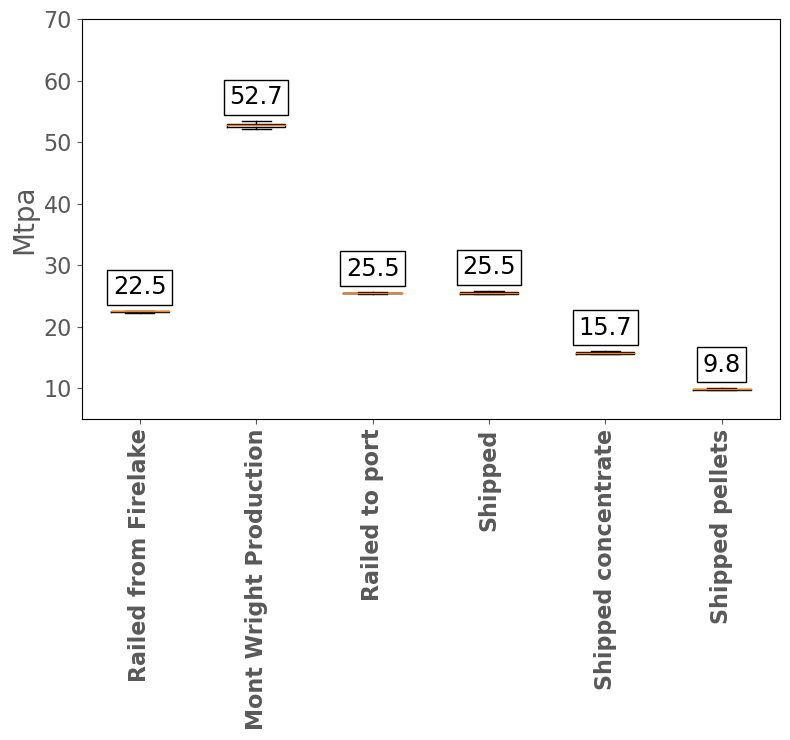

In [445]:
from matplotlib.offsetbox import TextArea, OffsetImage, AnnotationBbox

fontSize = 20
labelSize = 16
fdict = {'fontsize': fontSize, 'color': "#595959"}
title='base_case_throughput'
df_fmt = dfdat[["[cvMWUnloadFL].TotalIn([Ore])/1[Mt]","[mineMW].TotalContentsRemoved/1[Mt]","sum([cvPC1a].TotalIn)/1[Mt]",
                "sum([cvToMarine].TotalIn)/1[Mt]","[cvToMarine].TotalIn([Concentrate])/1[Mt]", "[cvToMarine].TotalIn([Pellets])/1[Mt]"]]
df_fmt.columns = ["Railed from Firelake","Mont Wright Production","Railed to port","Shipped","Shipped concentrate","Shipped pellets"]
fig, ax = plt.subplots(1,figsize=(8,7.5))

label = 'Mtpa'
bp = ax.boxplot(df_fmt,showfliers=False)
ax.set_ylabel(label, size=fontSize, fontdict=fdict)
ax.set_xticks(range(1, len(df_fmt.columns) + 1))
ax.set_xticklabels(df_fmt.columns, fontsize=12,fontweight='bold') 
plt.xticks(rotation=90)
ax.tick_params(labelsize=labelSize, colors="#595959")
offset=3.8
for i in range(len(df_fmt.columns)):
    #offsetbox = TextArea(str(round(np.median(df_fmt.iloc[:,i]),1)), {'fontweight': 'bold','size':'xx-large'})
    offsetbox = TextArea(str(round(np.median(df_fmt.iloc[:,i]),1)), {'size':'xx-large'})
    ab = AnnotationBbox(offsetbox,
                        (i + 1, bp['whiskers'][2 * i + 1].get_ydata().max() + offset),
                        xybox=(0,0), 
                        xycoords='data',
                        boxcoords="offset points")   # can change fontsize here too
    ax.add_artist(ab)

ax.set_ylim(5,70)
ax.set_xlabel("")
plt.tight_layout()
#plt.savefig(f"{title}.png", dpi=600, bbox_inches = "tight" )
plt.show()

<AxesSubplot:ylabel='Frequency'>

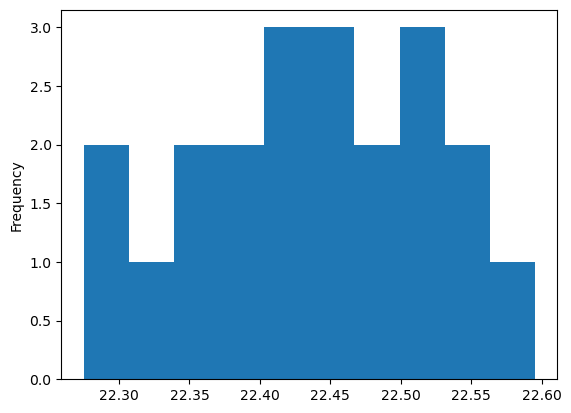

In [446]:
dfdat["[cvMWUnloadFL].TotalIn([Ore])/1[Mt]"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

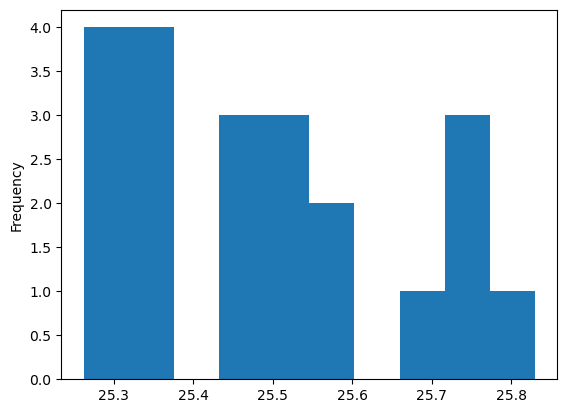

In [447]:
dfdat["sum([cvToMarine].TotalIn)/1[Mt]"].plot.hist()

12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrainCycles-s1r1.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrainCycles-s1r10.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrainCycles-s1r11.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrainCycles-s1r12.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrainCycles-s1r13.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFL

Text(0.95, 0.95, 'median: 7.17 h')

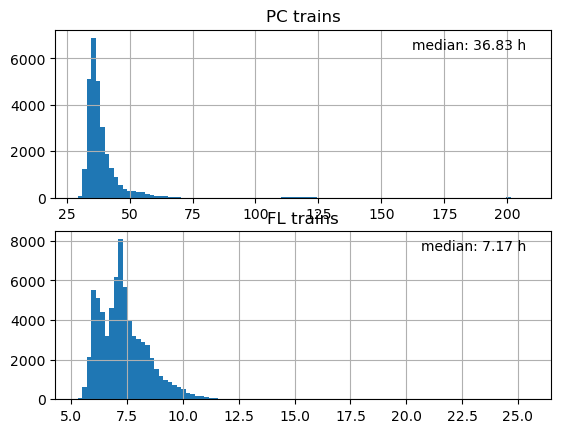

In [448]:

df_cycles = read_multi_run_log(run_root, "exLogTrainCycles")
df_cycles.rename(columns=lambda x: x.replace("this.","").replace("/1[h]","_hrs"),inplace=True)
df_cycles = df_cycles[df_cycles.SimTime_hrs>warmup_time]


df_cycl_fl = read_multi_run_log(run_root, "exLogTrainCyclesFL")
df_cycl_fl.rename(columns=lambda x: x.replace("this.","").replace("/1[h]","_hrs"),inplace=True)
df_cycl_fl = df_cycl_fl[df_cycl_fl.SimTime_hrs>warmup_time]


nbins = 100
_,ax = plt.subplots(2)
df_cycles.lastCycleTime.hist(bins=nbins, ax=ax[0])
cmed = df_cycles.lastCycleTime.median()
ax[0].annotate(f"median: {cmed:.2f} h",(.95,.95),xycoords="axes fraction",ha="right",va="top")
ax[0].set_title("PC trains")

df_cycl_fl.lastCycleTime.hist(bins=nbins, ax=ax[1])
cmed = df_cycl_fl.lastCycleTime.median()
ax[1].set_title("FL trains")
ax[1].annotate(f"median: {cmed:.2f} h",(.95,.95),xycoords="axes fraction",ha="right",va="top")

In [449]:
# column_renames = [(r"this\.SimTime","time_hrs"),
#                   (r"\[[Tt]rain.*\]\.State","loc_state"),
#                   (r"\[ESys[Tt]rain.*\]\.State","state_cargo"),
#                   ]

# dfs = []
# for proot, dirs, files in os.walk(os.path.join(run_root,"Outputs")):
#     for f in files:
#         if re.match(r".*exLogTrain.*State\.log", f):
#             train_id = re.match(r".*exLogTrain(.*)State\.log", f).groups()[0]
#             log_fn = os.path.join(proot, f)
#             df = read_multi_run_log(log_fn)
#             for m, new_name in column_renames:
#                 for col in df.columns:
#                     if re.match(m, col):
#                         df = df.rename(columns={col:new_name})
#             df["train_id"] = train_id
#             dfs.append(df)
            

# df = pd.concat(dfs)

In [450]:
def get_location(x):
    parts = x.split("-")
    if len(parts)==2:
        p = parts[0]
        return parts[0]
    else:
        return ""

def read_train_logs(run_root):
    patt = r".*exLogTrain(.*)State-s(\d+)r(\d+)\.log"
    threaded_logs = find_files_re(run_root+"/Outputs", patt)
    
    column_renames = [(r"this\.SimTime","time_hrs"),
                    (r"\[[Tt]rain.*\]\.State","loc_state"),
                    (r"\[ESys[Tt]rain.*\]\.State","state_cargo"),
                    ]

    if len(threaded_logs) > 0:
        #print(threaded_logs)
        dfs = []
        train_ids = set(re.match(r".*Train(.+)State.*", x).groups()[0] for x in threaded_logs)
        for train_id in train_ids:
            df = read_threaded_multi_run_log(run_root, f"exLogTrain{train_id}State")
            for m, new_name in column_renames:
                for col in df.columns:
                    if re.match(m, col):
                        df = df.rename(columns={col:new_name})
            df["TrainId"] = train_id
            dfs.append(df)

    else:
        dfs = []
        for proot, dirs, files in os.walk(os.path.join(run_root,"Outputs")):
            for f in files:
                if re.match(r".*exLogTrain.*State\.log", f):
                    
                    train_id = re.match(r".*exLogTrain(.*)State\.log", f).groups()[0]
                    log_fn = os.path.join(proot, f)
                    print(log_fn)
                    #df = read_multi_run_log(log_fn, f"exLogTrain{train_id}State")
                    df = read_multi_run_log_single_file(log_fn)
                    for m, new_name in column_renames:
                        for col in df.columns:
                            if re.match(m, col):
                                df = df.rename(columns={col:new_name})
                    df["TrainId"] = train_id
                    dfs.append(df)
                    
    df = pd.concat(dfs).sort_values(["Run","TrainId","SimTime_hrs"]).reset_index(drop=True)
    endtimes = df.sort_values(["Run","TrainId","SimTime_hrs"]).groupby(["Run","TrainId"]).SimTime_hrs.transform(lambda x:x.shift(-1))
    df["EndTime_hrs"] = endtimes
    df["location"] = df.loc_state.apply(get_location)
    df["status"] = df.loc_state.apply(lambda x:x.split("-")[-1])   

    return df 

df = read_train_logs(run_root)

12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrain05State-s1r1.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrain05State-s1r10.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrain05State-s1r11.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrain05State-s1r12.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x80ocFLTrn_Quebec_pls2-exLogTrain05State-s1r13.log
12 C:/JSPRuns/2025-03-14-124415_AMMC_5102_Base_3x80ocFLTrn_Quebec_pls2/Outputs\5102_Base_3x80ocFLTrn_Quebec_pls2\5102_Base_3x8

In [451]:
df.iloc[::1000]

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
0,0.000000,yPCTrainLoop-Working,Driving Empty,1,1,01,0.403086,yPCTrainLoop,Working
1000,259.854239,yFox1A-Working,Driving Empty,1,1,01,259.933400,yFox1A,Working
2000,517.614522,yJigtoD-Working,Driving Empty,1,1,01,517.846003,yJigtoD,Working
3000,791.828993,yRobtoSAM-Working,Driving Empty,1,1,01,792.057203,yRobtoSAM,Working
4000,1078.888221,ySAMToMWSiding(R)-Working,Driving Loaded,1,1,01,1079.098037,ySAMToMWSiding(R),Working
...,...,...,...,...,...,...,...,...,...
7909000,8743.805747,yRob1B-Working,Driving Loaded,21,1,FL03,8743.853097,yRob1B,Working
7910000,8913.363630,sdFLLoading-Working,Driving Loaded,21,1,FL03,8913.364439,sdFLLoading,Working
7911000,9084.861967,ySAM1B(R)-Working,Driving Empty,21,1,FL03,9084.985164,ySAM1B(R),Working
7912000,9246.702909,tulMW-PreUnloading,Pre-Unloading,21,1,FL03,9246.786243,tulMW,PreUnloading


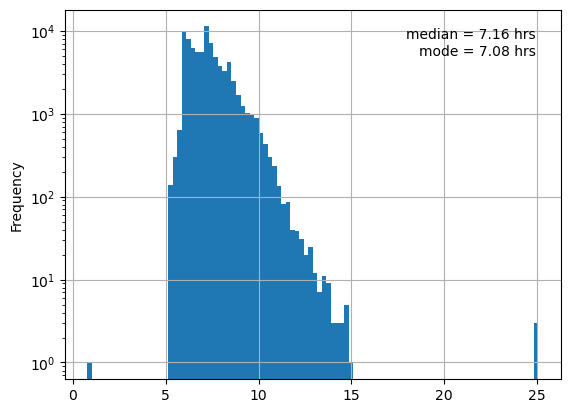

In [452]:
nbins = 100
dfl = df[df.TrainId.str.contains("FL")]
dfc = dfl[dfl.loc_state=="sdFLLoading-Working"].copy() 
dfc["cycle_time_hrs"] = dfc.groupby(["TrainId","Run"]).SimTime_hrs.transform(lambda x: x.diff())
dfc[dfc.cycle_time_hrs>0].cycle_time_hrs.plot.hist(bins=nbins)
cthist, bins = np.histogram(dfc[dfc.cycle_time_hrs>0].cycle_time_hrs,bins=nbins)
ctmode = bins[np.argmax(cthist)]
ctmed = dfc[dfc.cycle_time_hrs>0].cycle_time_hrs.median()
plt.annotate(f"median = {ctmed:.2f} hrs\nmode = {ctmode:.2f} hrs",
             (.95,.95),xycoords="axes fraction",ha="right",va="top")
plt.yscale("log")
plt.grid(True)

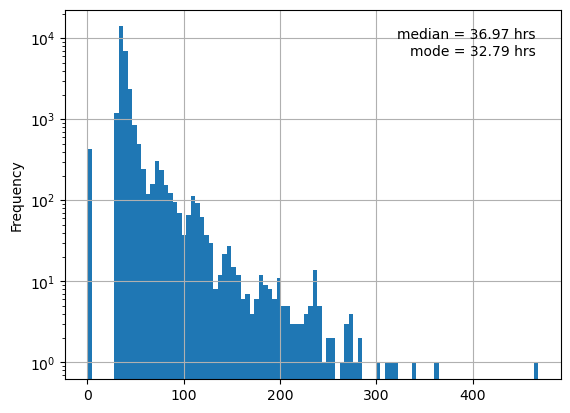

In [453]:
dfp = df[~df.TrainId.str.contains("FL")]
dfc = dfp[dfp.loc_state=="yPCdeparture-Working"].copy() 
dfc["cycle_time_hrs"] = dfc.groupby(["TrainId","Run"]).SimTime_hrs.transform(lambda x: x.diff())
dfc[dfc.cycle_time_hrs>0].cycle_time_hrs.plot.hist(bins=nbins)
cthist, bins = np.histogram(dfc[dfc.cycle_time_hrs>0].cycle_time_hrs,bins=nbins)
ctmode = bins[np.argmax(cthist)]
ctmed = dfc[dfc.cycle_time_hrs>0].cycle_time_hrs.median()
plt.annotate(f"median = {ctmed:.2f} hrs\nmode = {ctmode:.2f} hrs",
             (.95,.95),xycoords="axes fraction",ha="right",va="top")
plt.yscale("log")
plt.grid(True)

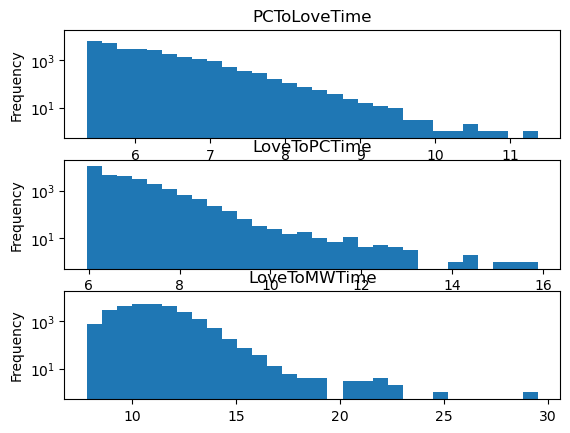

In [454]:
_,axs = plt.subplots(3)
for ax, col in zip(axs, ['PCToLoveTime', 'LoveToPCTime', 'LoveToMWTime']):
    df_cycles.loc[df_cycles[col]<40,col].plot.hist(bins=30, ax=ax)
    #ax.set_xlim(0,12)
    ax.set_title(col)
    ax.set_yscale("log")
    ax.set_ylim(.5,20000)

Text(0, 0.5, 'Last cycle time (hrs)')

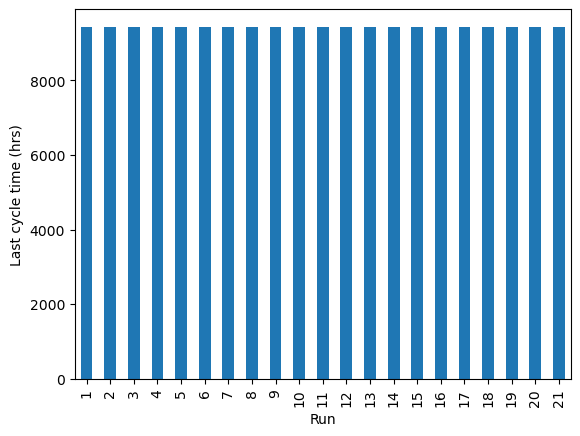

In [455]:
val_col = "SimTime_hrs"
grp_col = "Run"
df_cycles.groupby(grp_col)[val_col].max().plot.bar()
plt.ylabel("Last cycle time (hrs)")

In [456]:
df_cycles.groupby(grp_col)[val_col].max()

Run
1     9428.602134
2     9423.495190
3     9427.717138
4     9429.886007
5     9428.368893
6     9422.715499
7     9428.389859
8     9429.404408
9     9430.098313
10    9427.580592
11    9431.905308
12    9428.910103
13    9430.396035
14    9427.507715
15    9424.644224
16    9430.057400
17    9429.451418
18    9428.539682
19    9428.694480
20    9430.711731
21    9421.252619
Name: SimTime_hrs, dtype: float64

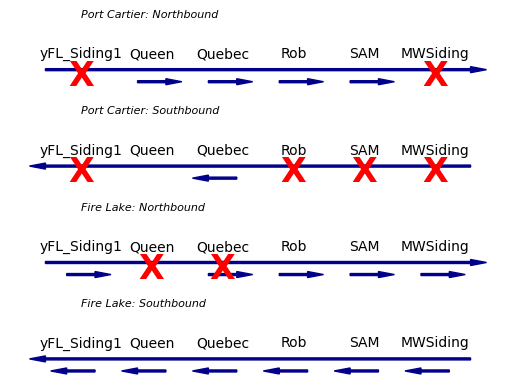

In [457]:
keep_states = ["Working","Blocked","Blocked_Max_Vehicles","Congestion","Delay","Idle"]
sidings = ["yFL_Siding1","Queen","Quebec","Rob","SAM","MWSiding"]

siding_logic = [
    # train type    direction       FL, Qn, Qb, Rob, Sam, MW
    ("Port Cartier", "Northbound", [ 0,  1,  1,   1,   1,  0], #Can use siding?
                                   [ 0,  1,  1,   1,   1,  0] #Can stop?
                                   ),
    ("Port Cartier", "Southbound", [ 0,  0,  1,   0,   0,  0], #Can use siding?
                                   [ 0,  1,  1,   0,   0,  0] #Can stop?
                                   ),
    ("Fire Lake",    "Northbound", [ 1,  0,  1,   1,   1,  1], #Can use siding?
                                   [ 1,  0,  0,   1,   1,  1] #Can stop?
                                   ),
    ("Fire Lake",    "Southbound", [ 1,  1,  1,   1,   1,  1], #Can use siding?
                                   [ 1,  1,  1,   1,   1,  1] #Can stop?
                                   ),
]

def all_locations_from_sidings_list(sidings, location_list=None):
    all_locs = [] 

    for sid in sidings:
        for add_str in ["","1"]:
            r = re.compile("(y?"+sid+add_str+")[AB]"+"(\(R\))?")
            matches = [re.match(r,x) for x in location_list]
            if not any(matches):
                continue
            else: 
                mlist = [x for x in matches if x is not None]
                #print(mlist, mlist[0].groups())
                suff = mlist[0].groups()[0]
            for branch in ["A", "B", ]:
                all_locs.append(suff+branch)
                all_locs.append(suff+branch+"(R)")
    
    return all_locs

def get_siding_logic(train_type="Port Cartier", direction="Northbound"):
    for sl in siding_logic:
        if sl[0] == train_type and sl[1]==direction:
            return sl
    raise ValueError("train type or direction not correct")

_, axs = plt.subplots(len(siding_logic))
bpos=.2
tpos=.8
asz=.2

def draw_siding_logic(ax=None, train_type="Port Cartier", direction="Northbound", sl=None):
    if ax is None:
        ax = plt.subplots(1)
    if sl is None:
        sl = get_siding_logic(train_type, direction)
    if sl[1] == "Northbound":
        ax.arrow(-.5,.5,len(sidings),0, color="darkblue",width=.05,length_includes_head=False)
    else:
        ax.arrow(len(sidings)-.5,.5,-len(sidings),0, color="darkblue",width=.05)
    for ii, (sd, su) in enumerate(zip(sidings, sl[2])):
        if su > 0:
            if sl[1] == "Northbound":
                ax.arrow(ii-asz,bpos,asz*2,0, color="darkblue",width=.05)
            else:
                ax.arrow(ii+asz,bpos,-asz*2,0, color="darkblue",width=.05)
        ax.text(ii,tpos, sd, ha="center")
    for ii, (sd, su) in enumerate(zip(sidings, sl[3])):
        if su==0:
            ax.text(ii,(.5+bpos)/2,"X", color="red",size=24, va="center", ha= "center", fontweight="heavy")    
    ax.set_ylim(0,2)
    ax.set_xlim(-1,len(sidings))
    ax.text(0,1.8, f"{sl[0]}: {sl[1]}", ha="left", size=8, style="italic", )
    ax.axis("off")

for ax, sl in zip(axs, siding_logic):
    draw_siding_logic(ax,sl=sl)

yFL_Siding1B(R)
MWSidingB
MWSidingB(R)
yQuebec1B


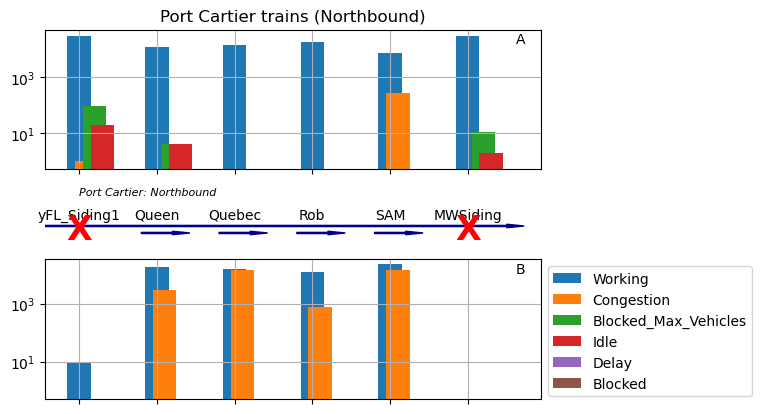

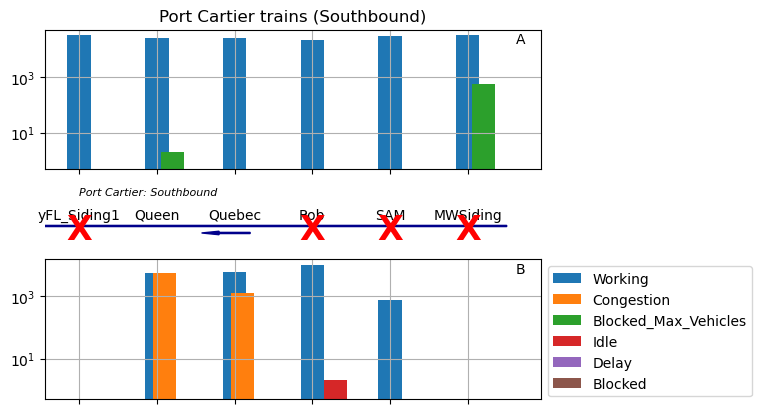

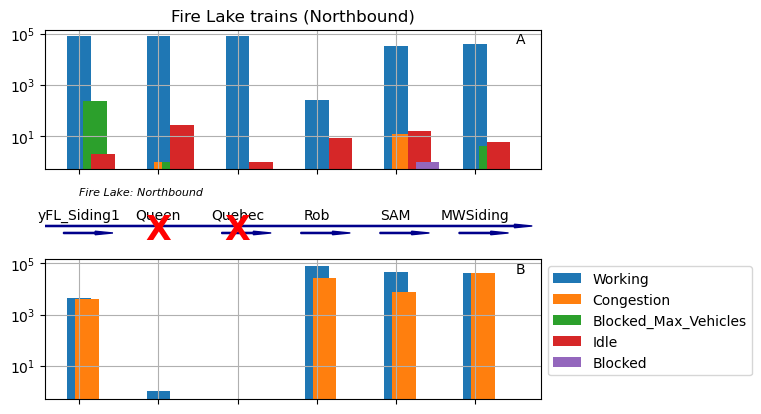

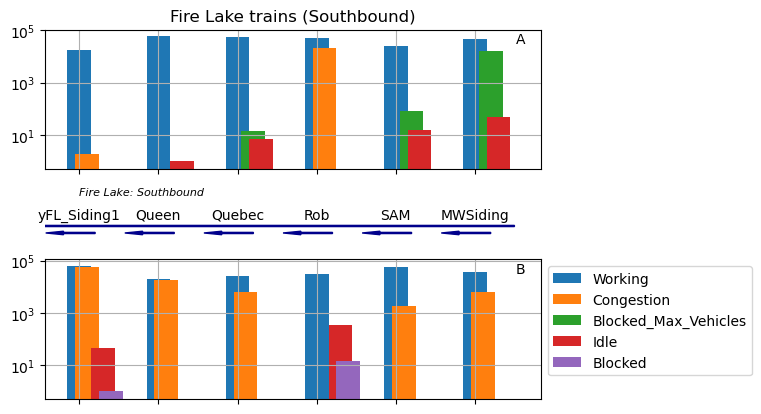

In [458]:
dfl = df[df.TrainId.str.contains("FL")]
dfp = df[~df.TrainId.str.contains("FL")]


for tlbl,dft in [("Port Cartier", dfp),("Fire Lake", dfl)]:
    tbl = dft.groupby(["location","status"]).SimTime_hrs.count().unstack().sort_index().fillna(0)
    location_list = df.location.unique()
    all_locs = all_locations_from_sidings_list(sidings, location_list=location_list)
    
    for l in all_locs:
        if l not in tbl.index:
            print(l)
            tbl.loc[l,:] = 0.0

    tbl = tbl.loc[all_locs,:]


    states = tbl[[x for x in keep_states if x in tbl.columns]].sum().sort_values().index


    tf = tbl[~tbl.index.str.contains("(R)",regex=False)]
    tr = tbl[tbl.index.str.contains("(R)",regex=False)]
    for direction, t1 in [("Northbound",tf),("Southbound",tr)]: 
        fig,axs = plt.subplots(3,gridspec_kw={"height_ratios":[3,1,3]} )

        for sid, ax in [("A",axs[0]),("B",axs[2])]:
            t = t1[t1.index.str.endswith(sid) | t1.index.str.endswith(sid+"(R)")]
            bottom = np.zeros(len(t))
            n = 0

            for col in reversed(states):
                if col in t.columns:
                    h = t.loc[:, col]
                    p = ax.bar(np.arange(len(t))+.1*n, h.values, .3, label=col, bottom=bottom)
                    #bottom += h
                    n+=1
                
            lbls = [x.get_text() for x in ax.get_xticklabels()]
            #ax.set_xticks(np.arange(len(t)))
            ax.set_xticklabels([])
            #plt.xticks(rotation=90)
            ax.set_yscale("log")
            ax.annotate(sid,(0.95,0.9),xycoords="axes fraction")
            lims = ax.get_ylim()
            ax.set_ylim([.5,lims[1]])
            ax.grid(True)

        plt.legend(loc="upper left", bbox_to_anchor=(1,1))


        axs[0].set_title(f"{tlbl} trains ({direction})")
        draw_siding_logic(axs[1], train_type=tlbl, direction=direction)
        #axs[1].axis('off')
        #axs[1].plot(np.arange(len(sidings)),np.ones(len(sidings))*np.nan)
        #axs[1].set_ylim([0,1])
        axs[1].set_xlim(axs[0].get_xlim())
        #for ii, sid in enumerate(sidings):
        #    axs[1].annotate(sid, (ii,.5), ha="center")
        #axs[1].set_xlim(axs[0].get_xlim())

In [459]:
df[df.loc_state.str.contains("yFL_Siding1A-Blocked")].sort_values(["Run","SimTime_hrs"])

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
71920,886.471881,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,1,1,03,886.476666,yFL_Siding1A,Blocked_Max_Vehicles
326507,1072.978259,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,1,1,FL03,1072.998753,yFL_Siding1A,Blocked_Max_Vehicles
44166,2657.773352,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,1,1,02,2657.776795,yFL_Siding1A,Blocked_Max_Vehicles
280693,2946.673965,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,1,1,FL02,2946.689723,yFL_Siding1A,Blocked_Max_Vehicles
281224,3034.850332,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,1,1,FL02,3034.855899,yFL_Siding1A,Blocked_Max_Vehicles
...,...,...,...,...,...,...,...,...,...
7665429,6978.230929,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,21,1,04,6978.235636,yFL_Siding1A,Blocked_Max_Vehicles
7785416,7091.012953,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,21,1,FL01,7091.020350,yFL_Siding1A,Blocked_Max_Vehicles
7902990,7734.951357,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,21,1,FL03,7734.967252,yFL_Siding1A,Blocked_Max_Vehicles
7791306,8071.736018,yFL_Siding1A-Blocked_Max_Vehicles,Congestion - Max Vehicles,21,1,FL01,8071.753516,yFL_Siding1A,Blocked_Max_Vehicles


In [460]:
df[df.loc_state.str.contains("MWSidingA-Blocked")].sort_values(["Run","SimTime_hrs"])

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
75642,1914.214030,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,1,1,03,1914.262359,MWSidingA,Blocked_Max_Vehicles
164999,7696.847812,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,1,1,05,7696.896133,MWSidingA,Blocked_Max_Vehicles
857635,734.222724,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,3,1,04,734.253755,MWSidingA,Blocked_Max_Vehicles
1681189,552.348066,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,5,1,06,552.390610,MWSidingA,Blocked_Max_Vehicles
2088989,9231.341207,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,6,1,06,9231.372237,MWSidingA,Blocked_Max_Vehicles
2918067,2588.784340,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,8,1,FL02,2588.836000,MWSidingA,Blocked_Max_Vehicles
3386032,8461.512623,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,9,1,FL03,8461.532668,MWSidingA,Blocked_Max_Vehicles
3472005,3078.943660,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,10,1,03,3078.998678,MWSidingA,Blocked_Max_Vehicles
4334325,4912.962323,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,12,1,06,4913.731309,MWSidingA,Blocked_Max_Vehicles
5621813,4544.073080,MWSidingA-Blocked_Max_Vehicles,Congestion - Max Vehicles,15,1,FL03,4544.161328,MWSidingA,Blocked_Max_Vehicles


In [461]:
df_cycles[df_cycles.lastCycleTime>100]

,SimTime_hrs,lastCycleTime,PCToLoveTime,LoveToPCTime,LoveToMWTime,lastTrain,Run,Scenario
677,4423.033521,118.439947,5.752986,6.548435,11.422386,TrainPC05,1,1
678,4427.721333,116.072269,5.574707,5.972167,10.819504,TrainPC06,1,1
679,4434.968970,115.655334,6.711066,6.692987,14.479814,TrainPC01,1,1
680,4439.715060,115.947775,5.370778,6.917774,12.924526,TrainPC02,1,1
681,4529.048622,201.305034,5.491738,7.947181,10.546512,TrainPC03,1,1
...,...,...,...,...,...,...,...,...
675,4532.470598,206.590419,5.597191,85.568317,11.924197,TrainPC03,9,1
676,4539.884089,117.828990,7.323398,7.413243,10.408146,TrainPC04,9,1
677,4544.350032,114.241414,5.651107,6.920485,11.560295,TrainPC05,9,1
678,4548.242587,112.949782,5.587629,6.063538,8.625788,TrainPC06,9,1


In [462]:
df[df.location.str.contains("Rob1") & (df.status != "Working")].groupby(["TrainId","status","location"]).Run.count().unstack()

location            yRob1A  yRob1A(R)  yRob1B  yRob1B(R)
TrainId status                                          
01      Breakdown      5.0        4.0     4.0        1.0
02      Breakdown      4.0        8.0     3.0        NaN
03      Breakdown      9.0        3.0     4.0        NaN
        Idle           NaN        NaN     NaN        2.0
04      Breakdown      5.0        8.0     1.0        3.0
05      Breakdown      3.0       16.0     3.0        1.0
06      Breakdown      NaN        NaN    11.0        6.0
        Congestion     NaN        NaN   766.0        NaN
FL01    Blocked        NaN        NaN     NaN        9.0
        Breakdown      NaN       28.0    41.0        9.0
        Congestion     NaN     6762.0  9017.0        NaN
        Idle           NaN        NaN     NaN      168.0
FL02    Breakdown      NaN       35.0    47.0       19.0
        Congestion     NaN     6899.0  9068.0        NaN
        Idle           NaN        NaN     NaN       83.0
FL03    Blocked        NaN        NaN     NaN        5.0
        Breakdown      1.0       34.0    44.0       19.0
        Congestion     NaN     6803.0  8931.0        NaN
        Idle           8.0        NaN     NaN      100.0

In [463]:
df1 = df.sort_values(["Run","TrainId","SimTime_hrs"]).reset_index(drop=True)
idx = df1[df1.loc_state.str.contains("bypass")].index


In [464]:
idx2 = sorted(np.concatenate([idx.values,idx.values+1]))
df1.loc[idx2]

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
1309432,2184.427248,yFL_Siding_bypass(R)-Working,Driving Loaded,4,1,06,2184.470809,yFL_Siding_bypass(R),Working
1309433,2184.470809,yFireLaketoQueen(R)-Working,Driving Loaded,4,1,06,2184.477437,yFireLaketoQueen(R),Working


In [465]:
endtimes = df.sort_values(["Run","TrainId","SimTime_hrs"]).groupby(["Run","TrainId"]).SimTime_hrs.transform(lambda x:x.shift(-1))

In [466]:
endtimes.sort_index()

0             0.403086
1             0.843242
2             3.843242
3             4.099415
4             4.315415
              ...     
7913115    9429.841545
7913116    9430.005456
7913117    9430.041639
7913118            NaN
7913119            NaN
Name: SimTime_hrs, Length: 7913120, dtype: float64

In [467]:
df[df.loc_state.str.contains("yQueen1") & df.TrainId.str.contains("FL")].loc_state.value_counts()

yQueen1A-Working                 81498
yQueen1A(R)-Working              60926
yQueen1B(R)-Working              20607
yQueen1B(R)-Congestion           18438
yQueen1A-Breakdown                 151
yQueen1A(R)-Breakdown              122
yQueen1B(R)-Breakdown               63
yQueen1A-Idle                       27
yQueen1A-Congestion                  1
yQueen1B-Working                     1
yQueen1A(R)-Idle                     1
yQueen1A-Blocked_Max_Vehicles        1
Name: loc_state, dtype: int64

In [468]:
df[df.TrainId.str.contains("FL") & (df.loc_state=="yQueen1A-Congestion")]

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
309306,7660.391384,yQueen1A-Congestion,Driving Loaded,1,1,FL02,7660.391886,yQueen1A,Congestion


In [469]:
df1 = df[df.Run==1]

In [470]:
df1s = df1.sort_values("SimTime_hrs")

In [471]:
df1s[df1s.loc_state.str.contains("bypass")]

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status


In [472]:
r1 = df1s[df1s.loc_state.str.contains("bypass")].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [ ]:
insiding = df1s[df1s.loc_state.str.contains("yFL_Siding1")]

In [ ]:
insiding[~((insiding.SimTime_hrs>r1.EndTime_hrs) | (insiding.EndTime_hrs<r1.SimTime_hrs))]

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
218233,29.435314,yFL_Siding1A-Congestion,Waiting Siding Loaded,1,1,FL02,30.431177,yFL_Siding1A,Congestion


In [ ]:
branch_names = ["yFL_Siding1A","yFL_Siding1B","yFL_Siding_bypass"]

mask = np.zeros(len(df),dtype="bool")

for b in branch_names:
    mask |= df.location.str.contains(b)

def find_overlaps(i1,il):
    mask = ~((i1[0]>il[1,:]) | (i1[1]<il[0,:]))
    return(np.flatnonzero(mask))

# for run, grp in df[mask].groupby("Run"):
#     times = np.vstack((grp.SimTime_hrs, grp.EndTime_hrs))
#     #grp.transform(lambda row: len(find_overlaps(np.array([row.StartTime_hrs, row.EndTime_hrs]), times)))
#     grp.apply(lambda row: len(find_overlaps(np.array([row.SimTime_hrs, row.EndTime_hrs]), times)))
    

In [ ]:
df[mask]

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
50,13.211962,yFL_Siding1A-Working,Driving Empty,1,1,01,13.229698,yFL_Siding1A,Working
80,19.032072,yFL_Siding1A(R)-Working,Driving Loaded,1,1,01,19.051959,yFL_Siding1A(R),Working
188,53.922717,yFL_Siding1A-Working,Driving Empty,1,1,01,53.940453,yFL_Siding1A,Working
222,61.484621,yFL_Siding_bypass(R)-Working,Driving Loaded,1,1,01,61.528182,yFL_Siding_bypass(R),Working
330,109.354355,yFL_Siding1A-Working,Driving Empty,1,1,01,109.372091,yFL_Siding1A,Working
...,...,...,...,...,...,...,...,...,...
6894929,9424.841076,yFL_Siding1B(R)-Working,Driving Empty,21,1,FL03,9424.877258,yFL_Siding1B(R),Working
6894930,9424.877258,yFL_Siding1B(R)-Congestion,Waiting Siding Empty,21,1,FL03,9425.397753,yFL_Siding1B(R),Congestion
6894939,9426.984549,yFL_Siding1A-Working,Driving Loaded,21,1,FL03,9427.046409,yFL_Siding1A,Working
6894974,9431.249694,yFL_Siding1B(R)-Working,Driving Empty,21,1,FL03,9431.285877,yFL_Siding1B(R),Working


In [ ]:
for run, grp in df[mask].groupby("Run"):
    
    #grp.transform(lambda row: len(find_overlaps(np.array([row.StartTime_hrs, row.EndTime_hrs]), times)))
    in_bypass = grp[grp.location.str.contains("bypass")]
    in_siding = grp[grp.location.str.contains("yFL_Siding1")]
    times = np.vstack((in_siding.SimTime_hrs, in_siding.EndTime_hrs))
    res = in_bypass.apply(lambda row: len(find_overlaps(np.array([row.SimTime_hrs, row.EndTime_hrs]), times)), axis=1)
    if any(res>1):
        print(run)
        #print(res)
        print(in_bypass[res>1].SimTime_hrs)#[res>1])
        

5
1408039    6509.767047
Name: SimTime_hrs, dtype: float64
13
4044424    5346.80161
Name: SimTime_hrs, dtype: float64
21
6711045    5183.999717
Name: SimTime_hrs, dtype: float64


In [ ]:
in_bypass

,SimTime_hrs,loc_state,state_cargo,Run,Scenario,TrainId,EndTime_hrs,location,status
6560288,95.935994,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,01,95.979555,yFL_Siding_bypass(R),Working
6560716,232.712045,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,01,232.755605,yFL_Siding_bypass(R),Working
6560862,271.455273,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,01,271.498833,yFL_Siding_bypass(R),Working
6561007,315.024406,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,01,315.067967,yFL_Siding_bypass(R),Working
6561151,368.005486,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,01,368.049046,yFL_Siding_bypass(R),Working
...,...,...,...,...,...,...,...,...,...
6722360,9145.777545,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,06,9145.821106,yFL_Siding_bypass(R),Working
6722640,9231.156803,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,06,9231.200364,yFL_Siding_bypass(R),Working
6722779,9276.925555,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,06,9276.969115,yFL_Siding_bypass(R),Working
6722925,9344.981910,yFL_Siding_bypass(R)-Working,Driving Loaded,21,1,06,9345.025471,yFL_Siding_bypass(R),Working


In [ ]:
find_overlaps(df1s.loc[100,["SimTime_hrs","EndTime_hrs"]].values,np.vstack((df1s.SimTime_hrs, df1s.EndTime_hrs)))

array([  4,   5,   6,   7,  13, 696, 701, 707, 712, 714, 715, 717, 718,
       719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729], dtype=int64)

In [ ]:
df1s.loc[100,["SimTime_hrs","EndTime_hrs"]].values[0]

21.958104956666663

In [ ]:
np.vstack((df1s.SimTime_hrs, df1s.EndTime_hrs))[0,:]

array([   0.        ,    0.        ,    0.        , ..., 9431.93010998,
       9431.93668867, 9431.98403867])